In [1]:
import torch, random
from diffusers import AutoencoderDC, SanaTransformer2DModel
from transformers import AutoModel, AutoTokenizer, Siglip2TextModel
from tqdm import tqdm
from pathlib import Path

from utils import (
    generate,
    pil_add_text,
    make_grid,
)
from utils_eval import get_random_prompts, pil_clipscore, generate_images_seed, generate_images_prompts

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

repo_model = "g-ronimo/hana-alpha44"
# repo_te = "answerdotai/ModernBERT-large"
repo_te = "HuggingFaceTB/SmolLM2-360M"
repo_ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

transformer = SanaTransformer2DModel.from_pretrained(repo_model).to(device).to(dtype)
tokenizer = AutoTokenizer.from_pretrained(repo_te, torch_dtype=dtype)

if "siglip2" in repo_te:
    text_encoder = Siglip2TextModel.from_pretrained(repo_te, torch_dtype=dtype).to(device)
elif "SmolLM2" in repo_te:
    text_encoder = AutoModel.from_pretrained(
        repo_te, 
        torch_dtype=dtype,
        # _attn_implementation="flash_attention_2" 
    ).to(device)
    tokenizer.pad_token = tokenizer.eos_token
else:
    text_encoder = AutoModel.from_pretrained(repo_te, torch_dtype=dtype).to(device)

dcae = AutoencoderDC.from_pretrained(repo_ae, subfolder="vae", torch_dtype=dtype).to(device)

config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [3]:
prompts = get_random_prompts(n=100)
prompts[:5]

['a man standing under a tree',
 'a rabbit',
 'inspiration',
 'an impressionist painting of the geyser Old Faithful',
 'a wooden toy horse with a mane made of rope']

In [4]:
cfgs = [5, 7]
seeds = [42, 883795, 805636, 813695, 58656, 240175, 861723, 33660, 844152, 330777, 420652]

In [5]:
pipeline_components = dict(
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    dcae=dcae,
)
inference_config = dict(
    # guidance_scale=4,
    latent_dim=[1, 32, 8, 8],
    # latent_seed = 9221672424,
    num_steps=20,
    max_prompt_tok_len=50,
)

100%|███████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.06s/it]


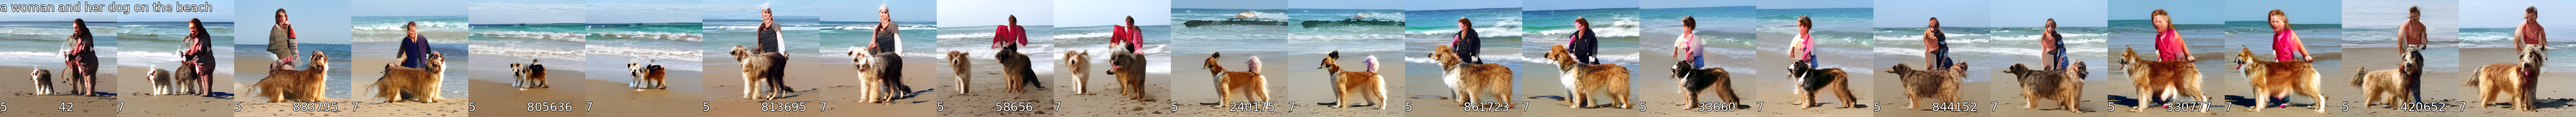

In [6]:
# # Test
imgs, gallery = generate_images_prompts(["a woman and her dog on the beach"], seeds, cfgs, pipeline_components, inference_config)
gallery[0]

In [ ]:
model_fn = repo_model.replace(" ","_").replace("/","_")

Path(model_fn).mkdir(parents=True, exist_ok=True)
Path(f"{model_fn}/single").mkdir(parents=True, exist_ok=True)

imgs, galleries = generate_images_prompts(prompts, seeds, cfgs, pipeline_components, inference_config)

# Save gallery
model_gallery = make_grid(galleries, rows=len(galleries), cols=1)
model_gallery.save(f"{model_fn}/gallery.png")

# Save single images
for i, img in enumerate(imgs):
    img.save(f"{model_fn}/single/{str(i)}_single.png")

# clip score
clip_score = pil_clipscore(imgs, [p for p in prompts for _ in seeds for _ in cfgs])

 17%|████████▊                                           | 17/100 [04:10<20:16, 14.65s/it]

In [8]:
clip_score

27.339296340942383

## n=20 
* alpha 37: 25.326217651367188
* alpha 38: 27.009260177612305

## n=100 
* alpha 35: 25.825515747070312
* alpha 37: 26.124223709106445
* alpha 38: 26.84288787841797
* alpha 39: 27.05074119567871
* alpha 41: 25.2694149017334
* alpha 42: 26.16070556640625
* alpha 44: 27.339296340942383
